In [26]:
# Example parameters
model_dir = './bpnet/examples/chip-nexus/output/'

gpu = 0
memfrac_gpu = 0.45
in_memory = False
num_workers = 8

In [27]:
import bpnet
import pandas as pd
import numpy as np
import os
from pathlib import Path

from bpnet.dataspecs import DataSpec, TaskSpec
from bpnet.utils import create_tf_session
from bpnet.seqmodel import SeqModel
from bpnet.plot.evaluate import plot_loss, regression_eval
from IPython.display import clear_output

In [28]:
model_dir = Path(model_dir)

In [29]:
history_file = model_dir / "history.csv"

In [30]:
create_tf_session(gpu)
clear_output()

In [32]:
model = SeqModel.from_mdir(model_dir)
clear_output()

## Evaluation

Print the metrics:

In [33]:
!cat {model_dir}/evaluation.valid.json

{
  "valid-peaks": {
    "Oct4/profile/binsize=1/auprc": 0.2988962008129486,
    "Oct4/profile/binsize=1/random_auprc": 0.10733649347249394,
    "Oct4/profile/binsize=1/n_positives": 17906,
    "Oct4/profile/binsize=1/frac_ambigous": 0.2969518272425249,
    "Oct4/profile/binsize=1/imbalance": 0.10576866279962668,
    "Oct4/profile/binsize=10/auprc": 0.8636563781189565,
    "Oct4/profile/binsize=10/random_auprc": 0.7731474464412409,
    "Oct4/profile/binsize=10/n_positives": 9216,
    "Oct4/profile/binsize=10/frac_ambigous": 0.5080564784053156,
    "Oct4/profile/binsize=10/imbalance": 0.7779841296640216,
    "Oct4/counts/mse": 1.327919840812683,
    "Oct4/counts/var_explained": -0.6340404748916626,
    "Oct4/counts/pearsonr": -0.019652674369757955,
    "Oct4/counts/spearmanr": -0.0273016972445214,
    "Oct4/counts/mad": 0.9159870743751526,
    "Sox2/profile/binsize=1/auprc": 0.2922871596759037,
    "Sox2/profile/binsize=1/random_auprc": 0.10754282518904301,
    "Sox2/profile/binsize=1/n

In [34]:
from bpnet.utils import read_json
gin_config = read_json(model_dir / 'config.gin.json')

In [14]:
from bpnet.datasets import StrandedProfile

In [1]:
ds = DataSpec.load(model_dir / 'dataspec.yml')
tasks = list(ds.task_specs)

NameError: name 'DataSpec' is not defined

In [15]:
dl_valid = StrandedProfile(ds, 
                           incl_chromosomes=gin_config['bpnet_data.valid_chr'], 
                           peak_width=gin_config['bpnet_data.peak_width'],
                           seq_width=gin_config['bpnet_data.seq_width'],
                           shuffle=False)

In [16]:
valid = dl_valid.load_all(num_workers=num_workers)

100%|██████████| 1/1 [00:00<00:00, 60.78it/s]


In [19]:
y_pred = model.predict(valid['inputs']['seq'])

In [20]:
y_true = valid['targets']

In [21]:
import matplotlib.pyplot as plt

/data/ouga/home/ag_gagneur/avsec/.conda/envs/bpnet/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/data/ouga/home/ag_gagneur/avsec/.conda/envs/bpnet/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/data/ouga/home/ag_gagneur/avsec/.conda/envs/bpnet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/data/ouga/home/ag_gagneur/avsec/.conda/envs/bpnet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/data/ouga/home/ag_gagneur/avsec/.conda/envs/bpnet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value en

<Figure size 432x288 with 0 Axes>

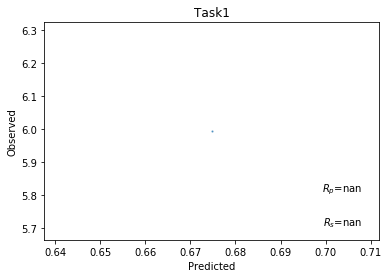

In [22]:
for task in tasks:
    plt.figure()
    yt = y_true[f'{task}/counts'].mean(-1)
    yp = y_pred[f'{task}/counts'].mean(-1)
    regression_eval(yt, 
                    yp, alpha=0.1, task=task)